In [1]:
from pandas import read_csv, DataFrame, to_numeric, concat
from numpy import nan
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import export_graphviz, DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from os.path import exists
import scoreValidator #I create this function for managing the score of each model

In [2]:
# Checking for existing files
fileAddress ="data_address.txt"
try:
    if exists(fileAddress):
        with open(fileAddress,'r') as text_file:
            Addrs = text_file.readlines()
            Addrs = [addrs.rstrip('\n') for addrs in Addrs]
            Addrs = [addrs.rstrip(' ') for addrs in Addrs]
        text_file.close()
    else:
        print("The file 'data_address.txt' must exists in the main directory. It contains all the address of pre-processed data to reutilize in each model. Please creat it and run this program again.")
        FileNotFoundError("The file 'data_address.txt' must exists in the main directory. It contains all the address of pre-processed data to reutilize in each model. Please creat it and run this program again.")
except:
    print("An error occurred when reading the file: 'data_address.csv'")
    RuntimeError("An error occurred when reading the file: 'data_address.csv'")

In [3]:
# Reading the three pre-processed files for the model
cleaned2 = DataFrame()
significance_filtered = DataFrame()
var_filtered = DataFrame()
try:
    cleaned2 = read_csv(Addrs[0],sep=',')#This is the data without the low variance, significance filter and outliers expulsion
    significance_filtered = read_csv(Addrs[1],sep=',')#This is the model with the significance filter
    var_filtered = read_csv(Addrs[2],sep=',')#This is the model with the low variance filter
except:
    print("Fatal Error: the pre-processed files was not found.")
    FileNotFoundError("Fatal Error: the pre-processed files was not found.")

In [4]:
#-----------------------------------------------
predictors_significance = significance_filtered.iloc[:,1:]
predictors_variance = var_filtered.iloc[:,1:]
#This class can be the same for both predictor_significance and predictor_variance because the number of rows didn't changed on those two filters
class_filtered = var_filtered.iloc[:,0]

In [5]:
#Splitting significance variables
X_train_significance, X_test_significance, y_train_significance, y_test_significance = train_test_split(predictors_significance,class_filtered,test_size=0.3,random_state=0)
#splitting variance variables
X_train_variance, X_test_variance, y_train_variance, y_test_variance = train_test_split(predictors_variance,class_filtered,test_size=0.3,random_state=0)


In [6]:
#Instantiating an object for each data set
forest_significance = RandomForestClassifier(n_estimators=100)
forest_variance = RandomForestClassifier(n_estimators=100)

In [7]:
#Fitting (finally)
forest_significance.fit(X_train_significance,y_train_significance)
forest_variance.fit(X_train_variance,y_train_variance)

RandomForestClassifier()

In [8]:
prediction_significance = forest_significance.predict(X_test_significance)
prediction_variance = forest_variance.predict(X_test_variance)

In [9]:
#Confusion matrix Significance
confusion_matrix_significance = confusion_matrix(y_test_significance,prediction_significance)
confusion_matrix_significance

array([[7304,    1],
       [  36,   16]], dtype=int64)

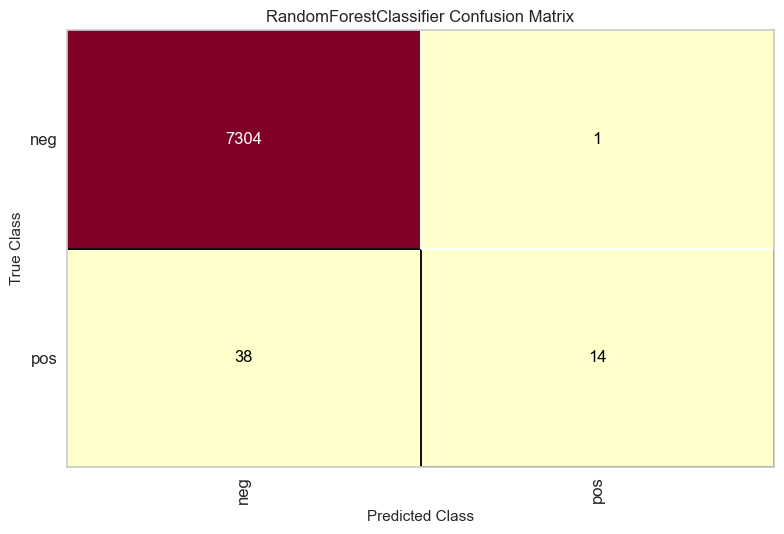

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [10]:
#Visualizing confusion matrix
visual_matrix_significance = ConfusionMatrix(RandomForestClassifier(n_estimators=100))
visual_matrix_significance.fit(X_train_significance,y_train_significance)
visual_matrix_significance.score(X_test_significance,y_test_significance)
visual_matrix_significance.poof()

In [11]:
#Confusion matrix Variance
confusion_matrix_variance = confusion_matrix(y_test_variance,prediction_variance)
confusion_matrix_variance

array([[7303,    2],
       [  41,   11]], dtype=int64)

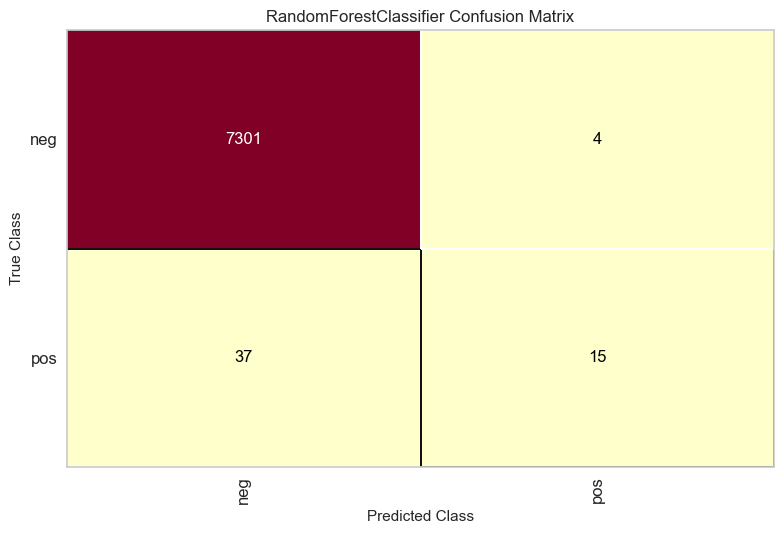

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [12]:
#Visualizing confusion matrix
visual_matrix_variance = ConfusionMatrix(RandomForestClassifier(n_estimators=100))
visual_matrix_variance.fit(X_train_variance,y_train_variance)
visual_matrix_variance.score(X_test_variance,y_test_variance)
visual_matrix_variance.poof()

In [13]:
#As espectected the most filtered one is the most precise
print('\n')
print("Score of the model Random Forest with Trees Classifier dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_significance))
print("----------------------------------------------------------------\n")
print('\n')
print("Score of the model Random Forest with low variance filter dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_variance))
print("----------------------------------------------------------------\n")



Score of the model Random Forest with Trees Classifier dimensionality reduction:

(The lower the best)


18410.0
----------------------------------------------------------------



Score of the model Random Forest with low variance filter dimensionality reduction:

(The lower the best)


20795.0
----------------------------------------------------------------



In [22]:
#Based on the previous result we choose to use the low variance dimensionality reduction for the next step
# Checking for existing files
try:
    present_year_raw = read_csv("Data/air_system_present_year.csv")    
except:
    print("An error occurred when reading the file: 'data_address.csv'")
    RuntimeError("An error occurred when reading the file: 'data_address.csv'")

In [23]:
#Cleaning input sample
X_present_year = DataFrame(present_year_raw[var_filtered.columns]).iloc[:,1:].replace("na",nan).apply(to_numeric)
y_present_year = DataFrame(present_year_raw[var_filtered.columns]).iloc[:,0]
new_present_year_raw = concat([y_present_year,X_present_year],axis=1).dropna() 
X_present_year = new_present_year_raw.iloc[:,1:]
y_present_year = new_present_year_raw.iloc[:,0]

In [24]:
prediction = forest_variance.predict(X_present_year)
confusion_matrix_var = confusion_matrix(y_present_year,prediction)
print(confusion_matrix_var)
print("Score of the model Naive Bayes with low variance filter dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_var))
print("----------------------------------------------------------------\n")
print("Score rate of the model Naive Bayes with low variance filter dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_var)/len(y_present_year))
print("----------------------------------------------------------------\n")

[[11792     3]
 [   53    26]]
Score of the model Naive Bayes with low variance filter dimensionality reduction:

(The lower the best)


27180.0
----------------------------------------------------------------

Score rate of the model Naive Bayes with low variance filter dimensionality reduction:

(The lower the best)


2.2890348660939868
----------------------------------------------------------------



In [26]:
#Optimizing the best model
#Naive Bayes happens to be the best model based in our accuracy definition, so now is the momento for optimizing the best this model and get the best results
from accuracyMeassure import accuracyMeassure
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from numpy import ndarray

def accuracyMeassure(y_true:ndarray,y_predict:ndarray)->float:
    confusion_matrix_var = confusion_matrix(y_true,y_predict)
    return scoreValidator.score(confution_matrix_var=confusion_matrix_var)
#Defining a custome score
custom_score = make_scorer(accuracyMeassure)
#Defining parameters to be tested, we let it in blanck because we want it to auto-change them
param_grid = {
    'n_estimators': [100, 400], 
    'max_depth': [None, 10, 30, 50], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False]
    }

grid_searcher = GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,cv=5,scoring=custom_score)
grid_searcher.fit(predictors_variance,class_filtered)

print("Best parameters found:\n")
print(grid_searcher.best_params_)
print("\n")
print("Best scores found:\n")
print(grid_searcher.best_score_)
print("\n")

prediction = grid_searcher.best_estimator_.predict(X_present_year)
confusion_matrix_var = confusion_matrix(y_present_year,prediction)
print(confusion_matrix_var)
print("Score of the model Decision Tree Classifier with variance dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_var))
print("----------------------------------------------------------------\n")
print("Score rate of the model Decision Tree Classifier with variance dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_var)/len(y_present_year))
print("----------------------------------------------------------------\n")

KeyboardInterrupt: 

In [ ]:
#Based on the previous result we choose to use the significance dimensionality reduction for the next step
# Checking for existing files
try:
    present_year_raw = read_csv("Data/air_system_present_year.csv")    
except:
    print("An error occurred when reading the file: 'data_address.csv'")
    RuntimeError("An error occurred when reading the file: 'data_address.csv'")
#Cleaning input sample
X_present_year = DataFrame(present_year_raw[significance_filtered.columns]).iloc[:,1:].replace("na",nan).apply(to_numeric)
y_present_year = DataFrame(present_year_raw[significance_filtered.columns]).iloc[:,0]
new_present_year_raw = concat([y_present_year,X_present_year],axis=1).dropna() 
X_present_year = new_present_year_raw.iloc[:,1:]
y_present_year = new_present_year_raw.iloc[:,0]
forest_significance = RandomForestClassifier(n_estimators=1000)
# Training the model with the whole data from previous years
forest_significance.fit(predictors_significance,class_filtered)
prediction = forest_significance.predict(X_present_year)
confusion_matrix_var = confusion_matrix(y_present_year,prediction)
print(confusion_matrix_var)
print("Score of the model Random Forest with significance dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_var))
print("----------------------------------------------------------------\n")
print("Score rate of the model Random Forest with significans dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_var)/len(y_present_year))
print("----------------------------------------------------------------\n")

[[6523    5]
 [  48   18]]
Score of the model Random Forest with significance dimensionality reduction:

(The lower the best)


24500.0
----------------------------------------------------------------

Score rate of the model Random Forest with significans dimensionality reduction:

(The lower the best)


3.715498938428875
----------------------------------------------------------------



In [ ]:
#Optimizing the best model
#Naive Bayes happens to be the best model based in our accuracy definition, so now is the momento for optimizing the best this model and get the best results
from accuracyMeassure import accuracyMeassure
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from numpy import ndarray

def accuracyMeassure(y_true:ndarray,y_predict:ndarray)->float:
    confusion_matrix_var = confusion_matrix(y_true,y_predict)
    return scoreValidator.score(confution_matrix_var=confusion_matrix_var)
#Defining a custome score
custom_score = make_scorer(accuracyMeassure)
#Defining parameters to be tested, we let it in blanck because we want it to auto-change them
param_grid = {
    'n_estimators': [100, 400], 
    'max_depth': [None, 10, 30, 50], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False]
    }

grid_searcher = GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,cv=5,scoring=custom_score)
grid_searcher.fit(predictors_significance,class_filtered)

print("Best parameters found:\n")
print(grid_searcher.best_params_)
print("\n")
print("Best scores found:\n")
print(grid_searcher.best_score_)
print("\n")

prediction = grid_searcher.best_estimator_.predict(X_present_year)
confusion_matrix_var = confusion_matrix(y_present_year,prediction)
print(confusion_matrix_var)
print("Score of the model Decision Tree Classifier with significance dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_var))
print("----------------------------------------------------------------\n")
print("Score rate of the model Decision Tree Classifier with significans dimensionality reduction:\n")
print("(The lower the best)")
print("\n")
print(scoreValidator.score(confusion_matrix_var)/len(y_present_year))
print("----------------------------------------------------------------\n")